# Projeto 1 - Ciência dos Dados


Nome: Enricco Gemha

Nome: Marcelo Rabello Barranco

Nome: Rafael Coca Leventhal


Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe


---

Carregando algumas bibliotecas:


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk

nltk.download('rslp');
nltk.download('stopwords');

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/enriccogemha/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enriccogemha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/enriccogemha/Documents/Documentos - iMac de Enricco/GitHub/projeto1-cdados


Carregando a base de dados com os tweets classificados com os critérios explicitados no README.md do projeto:

In [36]:
filename = 'iphone.xlsx'

In [37]:
train = pd.read_excel(filename)
train.head()

,Treinamento,RELEVÂNCIA
0,- pego meu iphone 15 pro max 6g\n- ligo pra mi...,0
1,@venusbillie ai fica tao mais bonito no iphone...,4
2,mas tambem quem compra iphone 6 em 2021 tem ma...,4
3,"feliz pra crl , pegar meu iphone agr 😅",4
4,@tatielly_keys vc tem iphone?,0


In [38]:
train.RELEVÂNCIA.value_counts(True)

0    0.277333
4    0.241333
2    0.204000
3    0.152000
1    0.125333
Name: RELEVÂNCIA, dtype: float64

In [39]:
test = pd.read_excel(filename, sheet_name='Teste')
test.head()

,Teste,RELEVÂNCIA
0,minha mãe podia me dá um iphone só de pena no ...,4
1,qria fazer a trend da tv alem de ser pequena n...,4
2,papo de q o whatsapp de quem tem iphone vai pa...,3
3,iphone 13 vai esperar mais um pouco pq a gata ...,4
4,alguém sabe se quando quebra a tela do iphone ...,3


---

## Classificador automático de sentimento


Produto: iPhone (dispensa descrições)

- MUITO IRRELEVANTE: falando de outro assunto, não envolve o iPhone, pessoas que não sabem tweetar ou se comunicar (Ex: só colocou uma hashtag)
- IRRELEVANTE: anúncios de venda (EX: venha comprar no magalu)
- NEUTRO: piada sobre o iPhone (EX: iPhone é o Corsa em miniatura kkkkkk)
- RELEVANTE: comentário indireto relacionado ao iPhone (EX: meu professor de ciências passou 30 minutos só falando do novo iPhone dele)
- MUITO RELEVANTE: falando objetivamente do iPhone, tipo opinião, dúvida ou desejo de comprar (EX: iPhone 13 vai esperar um pouco para chegar em minhas mãos)

* MUITO IRRELEVANTE = 0
* IRRELEVANTE = 1
* NEUTRO = 2
* RELEVANTE = 3
* MUITO RELEVANTE = 4


---

### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine seu classificador.


### Definindo a função de limpeza dos Tweets

A função abaixo é responsável por remover, respectivamente: 
- links (tipos HTTP, HTTPS e FTP) 
- tags de usernames (@)
- sinais de pontuação (! - _ . : ? ; [] \ /)

Além disso, a função também é responsável por realizar os seguintes processos:
- STEMMING (descrito na documentação do NLTK como: "A processing interface for removing morphological affixes from words.")

- TOKENIZING (descrito pela documentação do NLTK como: "A tokenizer that divides a string into substrings by splitting on the specified string (defined in subclasses).")

In [40]:
def clean_data(text):
    # remover endereço
    http_re = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    text = re.sub(http_re, '', text)

    # remover usernames
    text = re.sub(r'@[^\s]*', '', text)

    # removendo sinais de pontuação
    text = re.sub(r'[!-_.:?;[\]/]', '', text)

    # tokenizing
    tokenizer = nltk.tokenize.casual.TweetTokenizer()
    text = tokenizer.tokenize(text)

    # stemming
    stemmer = nltk.stem.RSLPStemmer()
    text = list(map(stemmer.stem, text))

    return text


In [41]:
# preparando os dados
train.loc[:, 'Treinamento'] = train.Treinamento.apply(clean_data)
train_relevancia = train.RELEVÂNCIA.map({
    0: 'muito irrelevante',
    1: 'irrelevante',
    2: 'neutro',
    3: 'relevante',
    4: 'muito relevante'
})

categorias = ['muito irrelevante', 'irrelevante',
              'neutro', 'relevante', 'muito relevante']

train.loc[:, 'RELEVÂNCIA'] = pd.Categorical(
    train_relevancia, categories=categorias, ordered=True
)
train.head()

,Treinamento,RELEVÂNCIA
0,"[peg, meu, iphon, pro, max, g, lig, pra, minh,...",muito irrelevante
1,"[ai, fic, tao, mais, bonit, no, iphon, q, dor, 💔]",muito relevante
2,"[mas, tamb, qu, compr, iphon, em, tem, mais, q...",muito relevante
3,"[feliz, pra, crl, peg, meu, iphon, agr, 😅]",muito relevante
4,"[vc, tem, iphon]",muito irrelevante
...,...,...
745,"[minh, mãe, qu, compr, o, iphon, pra, ela, e, ...",muito relevante
746,"[nunc, precis, mex, no, meu, iphon, se, antig,...",muito irrelevante
747,"[era, só, um, carreg, de, iphon, 😪]",muito irrelevante
748,"[tô, doid, com, ess, películ, privacidadee, vi...",relevante


In [42]:
train.RELEVÂNCIA.describe()

count                   750
unique                    5
top       muito irrelevante
freq                    208
Name: RELEVÂNCIA, dtype: object

## Construindo o Classificador Naïve-Bayes

O processo consiste em ensinar o classificador, com base nos tweets coletados SOMENTE na planilha de treinamento (train), com os seguintes passos:
<ol>
    <li>
        criar uma lista com as categorias de relevâncias
    </li>
    <li>
        criar uma lista de palavras com somente 1 ocorrência por todos os tweets
    </li>
    <li>
        criar um dicionário com as palavras de cada categoria
    </li>
    <li>
        criar um dicionário com o número de vezes que cada palavra é mencionada
    </li>
</ol>

In [43]:
# construindo classificador
categorias = ['muito irrelevante', 'irrelevante',
              'neutro', 'relevante', 'muito relevante']

# lista de palavras/emojis presentes em toda a base de dados
total_de_palavras = sum(train.Treinamento, [])

# número de palavras/emojis únicos presentes em toda a base de dados
palavras_unicas = set(total_de_palavras)

# dicionário de palavras por categoria
palavras_por_categoria = {
    categoria: sum(train[train.RELEVÂNCIA == categoria].Treinamento, [])
    for categoria in categorias
}

# número de ocorrências de palavra por categoria
ocorrencia_de_palavras_por_categoria =  {
    categoria: {
        palavra: palavras_por_categoria[categoria].count(palavra)
        for palavra in palavras_unicas
    }
    for categoria in categorias
}

# probabalidade por categoria
prob_por_categoria = {
    categoria: len(palavras_por_categoria[categoria]) / len(total_de_palavras)
    for categoria in categorias
}

## Probabilidade

Nesta seção, o processo consiste em definir a probabilidade de ser uma categoria dado o evento frase.

In [44]:
# definindo função que calcula a probabilidade de frase pertencer a determinada categoria
def prob_frase(categoria, frase):
    '''
    Calcula a probabilidade de frase estar em categoria
    '''
    # limpeza de frase caso forneciada no formato de str
    if frase is str:
        frase = clean_data(frase)
    # cálculo da probabilidade
    return prob_por_categoria[categoria] * np.array(list(
        # probabilidade de cada palavra com suavização de laplace
        (((ocorrencia_de_palavras_por_categoria[categoria][palavra] + 1)
        if palavra in palavras_unicas else 1) /
         (len(palavras_por_categoria[categoria]) + len(palavras_unicas)))
        for palavra in frase
    )).prod()  # produto da probabilidade de cada palavra

## Montando a função do classificador

Por fim, estrutura-se a função classificador, responsável por retornar a categoria com a maior chance de conter a dada frase, utilizando a probabilidade calculada na célula anterior.

In [45]:
def classificador(frase):
    '''
    Retorna a categoria com a maior probabilidade de conter frase
    '''
    return max(
        categorias, key=lambda categoria: prob_frase(categoria, frase)
    )

---

### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.


In [46]:
# verificando o df que trabalharemos
test.head()

,Teste,RELEVÂNCIA
0,minha mãe podia me dá um iphone só de pena no ...,4
1,qria fazer a trend da tv alem de ser pequena n...,4
2,papo de q o whatsapp de quem tem iphone vai pa...,3
3,iphone 13 vai esperar mais um pouco pq a gata ...,4
4,alguém sabe se quando quebra a tela do iphone ...,3
...,...,...
245,qual iphone compensa pegar agora em 2021?,3
246,meta de maria:\nganhar um iphone 12 da melhor ...,4
247,"usando o combo iphone, macbook e airpods é per...",3
248,medo. prefiro ficar sem iphone https://t.co/ro...,4


In [47]:
# preparando df de teste
test.loc[:, 'Teste'] = test.Teste.apply(clean_data)
test_relevancia = test.RELEVÂNCIA.map(
    {0: 'muito irrelevante',
     1: 'irrelevante',
     2: 'neutro',
     3: 'relevante',
     4: 'muito relevante'}
)

# criando as categorias do teste
categorias_test = ['muito irrelevante', 'irrelevante',
              'neutro', 'relevante', 'muito relevante']

# unificacando as informações fornecidas pela classificação "na mão"
test.loc[:, 'RELEVÂNCIA'] = pd.Categorical(
    test_relevancia, categories=categorias_test, ordered=True
)
test.head()

,Teste,RELEVÂNCIA
0,"[minh, mãe, pod, me, dá, um, iphon, só, de, pe...",muito relevante
1,"[qri, faz, a, trend, da, tv, alem, de, ser, pe...",muito relevante
2,"[pap, de, q, o, whatsapp, de, qu, tem, iphon, ...",relevante
3,"[iphon, vai, esper, mais, um, pouc, pq, a, gat...",muito relevante
4,"[alguém, sab, se, qu, quebr, a, tel, do, iphon...",relevante
...,...,...
245,"[qual, iphon, compens, peg, agor, em]",relevante
246,"[met, de, mar, ganh, um, iphon, da, melhor, amig]",muito relevante
247,"[us, o, comb, iphon, macbook, e, airpod, é, pe...",relevante
248,"[med, prefir, fic, sem, iphon]",muito relevante


In [48]:
# aplicando o classificador na tabela de teste
test.loc[:, 'Classificador'] = pd.Categorical(
    test.Teste.apply(classificador), categories=categorias, ordered=True
)
test.head()

,Teste,RELEVÂNCIA,Classificador
0,"[minh, mãe, pod, me, dá, um, iphon, só, de, pe...",muito relevante,relevante
1,"[qri, faz, a, trend, da, tv, alem, de, ser, pe...",muito relevante,relevante
2,"[pap, de, q, o, whatsapp, de, qu, tem, iphon, ...",relevante,muito irrelevante
3,"[iphon, vai, esper, mais, um, pouc, pq, a, gat...",muito relevante,relevante
4,"[alguém, sab, se, qu, quebr, a, tel, do, iphon...",relevante,neutro
...,...,...,...
245,"[qual, iphon, compens, peg, agor, em]",relevante,muito relevante
246,"[met, de, mar, ganh, um, iphon, da, melhor, amig]",muito relevante,muito relevante
247,"[us, o, comb, iphon, macbook, e, airpod, é, pe...",relevante,muito relevante
248,"[med, prefir, fic, sem, iphon]",muito relevante,neutro


In [49]:
# performance da classificação feita na própria base de treinamento
sum(train.RELEVÂNCIA == train.Treinamento) / train.shape[0]

0.0

In [50]:
# mostrando a performance do classificador
sum(test.RELEVÂNCIA == test.Classificador) / test.shape[0]

0.32

In [51]:
# criando um crosstab, contendo a taxa de acerto do teste por relevância
test['Acertos'] = test.Classificador == test.RELEVÂNCIA
pd.crosstab(test.Acertos, test.RELEVÂNCIA, normalize='columns')

RELEVÂNCIA,muito irrelevante,irrelevante,neutro,relevante,muito relevante
Acertos,,,,,
False,0.55814,0.842105,0.6,0.953125,0.515625
True,0.44186,0.157895,0.4,0.046875,0.484375


In [52]:
# criando um crosstab para avaliar a correspondência de relevância
pd.crosstab(test.Classificador, test.RELEVÂNCIA)

RELEVÂNCIA,muito irrelevante,irrelevante,neutro,relevante,muito relevante
Classificador,,,,,
muito irrelevante,19,7,21,25,14
irrelevante,2,3,0,0,1
neutro,6,5,24,14,11
relevante,1,0,0,3,7
muito relevante,15,4,15,22,31


# Entendendo melhor o conceito do classificador Naive-Bayes


O classificador não pode ser utilizar ele mesmo para gerar mais tweets para classificar, pois ele ficaria enviesado, por não serem geradas novas amostras, com novas palavras, mas sim amostras reutilizando a mesma gama de palavras.

---

### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste


# Novas iterações
Decidiu-se implementar uma randomização na separação dos tweets entre Treinamento e Teste, com a acurácia de 100 repetições. **Segue abaixo.**

In [53]:
# juntando ambos dataframes, Treinamento e Teste
df_complete = pd.DataFrame({
    'Tweets': train.Treinamento.append(test.Teste, ignore_index=True),
    'Relevancia': train.RELEVÂNCIA.append(test.RELEVÂNCIA, ignore_index= True),
})
df_complete.head()

,Tweets,Relevancia
0,"[peg, meu, iphon, pro, max, g, lig, pra, minh,...",muito irrelevante
1,"[ai, fic, tao, mais, bonit, no, iphon, q, dor, 💔]",muito relevante
2,"[mas, tamb, qu, compr, iphon, em, tem, mais, q...",muito relevante
3,"[feliz, pra, crl, peg, meu, iphon, agr, 😅]",muito relevante
4,"[vc, tem, iphon]",muito irrelevante
...,...,...
995,"[qual, iphon, compens, peg, agor, em]",relevante
996,"[met, de, mar, ganh, um, iphon, da, melhor, amig]",muito relevante
997,"[us, o, comb, iphon, macbook, e, airpod, é, pe...",relevante
998,"[med, prefir, fic, sem, iphon]",muito relevante


In [54]:
# recriando as categorias classificativas

new_relevancia = []
for r in df_complete.Relevancia:
    if r == "muito irrelevante":
        r = "irrelevante"
    if r == "muito relevante":
        r = "relevante"
    new_relevancia.append(r)
df_complete["Relevancia"] = new_relevancia
df_complete.head()

,Tweets,Relevancia
0,"[peg, meu, iphon, pro, max, g, lig, pra, minh,...",irrelevante
1,"[ai, fic, tao, mais, bonit, no, iphon, q, dor, 💔]",relevante
2,"[mas, tamb, qu, compr, iphon, em, tem, mais, q...",relevante
3,"[feliz, pra, crl, peg, meu, iphon, agr, 😅]",relevante
4,"[vc, tem, iphon]",irrelevante
...,...,...
995,"[qual, iphon, compens, peg, agor, em]",relevante
996,"[met, de, mar, ganh, um, iphon, da, melhor, amig]",relevante
997,"[us, o, comb, iphon, macbook, e, airpod, é, pe...",relevante
998,"[med, prefir, fic, sem, iphon]",relevante


In [55]:
# construindo a lista de categorias
categorias = ['irrelevante','neutro', 'relevante']

# lista da performance do classificador
performances = []

# fazendo o teste de performance 100 vezes
for _ in range(100):
    # randomizando tweets
    df_complete = df_complete.sample(frac=1).reset_index(drop=True)
    train = df_complete.iloc[:750]
    test = df_complete.iloc[750:1000]

    # número de palavras/emojis presentes em toda a base de dados
    total_de_palavras = sum(train.Tweets, [])
    # número de palavras/emojis únicos presentes em toda a base de dados
    palavras_unicas = set(total_de_palavras)

    # lista de palavras por categoria
    palavras_por_categoria = {
        categoria: sum(train[train.Relevancia == categoria].Tweets, [])
        for categoria in categorias
    }

    # número de ocorrências de palavra por categoria
    ocorrencia_de_palavras_por_categoria =  {
        categoria: {
            palavra: palavras_por_categoria[categoria].count(palavra)
            for palavra in palavras_unicas
        }
        for categoria in categorias
    }

    # probabalidade por categoria
    prob_por_categoria = {
        categoria: len(palavras_por_categoria[categoria]) / len(total_de_palavras)
        for categoria in categorias
    }


    def prob_frase(categoria, frase):
        '''
        Calcula a probabilidade de frase estar em categoria
        '''
        # limpeza de frase caso forneciada no formato de str
        if frase is str:
            frase = clean_data(frase)
        
        # cálculo da probabilidade
        return prob_por_categoria[categoria] * np.array(list(
            # probabilidade de cada palavra com suavização de laplace
            (((ocorrencia_de_palavras_por_categoria[categoria][palavra] + 1)
            if palavra in palavras_unicas else 1) /
            (len(palavras_por_categoria[categoria]) + len(palavras_unicas)))
            for palavra in frase
        )).prod()  # produto da probabilidade de cada palavra


    def classificador(frase):
        '''
        Retorna a categoria com a maior probabilidade de conter frase
        '''
        return max(
            categorias, key=lambda categoria: prob_frase(categoria, frase)
        )


    acertos = sum(test.Tweets.apply(classificador) == test.Relevancia)
    performance = acertos / test.shape[0]
    performances.append(performance)


In [56]:
# obtendo algumas informações importantes para análise dos 100 testes
pd.Series(performances).describe()

count    100.000000
mean       0.426120
std        0.031437
min        0.360000
25%        0.404000
50%        0.424000
75%        0.445000
max        0.500000
dtype: float64

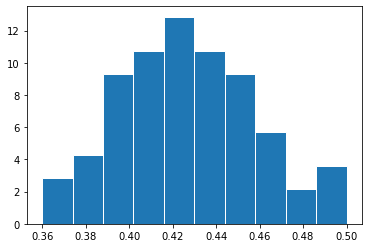

In [57]:
# plotando o histograma referente aos 100 testes
plt.hist(performances, edgecolor='white', density=True)
plt.title('Histograma das performances obtidas ao montar 100 classificadores')
plt.ylabel('Densidade')
plt.xlabel('Performances')
plt.show()

<p>
<hr></hr>
</p>

# CONCLUSÃO
<p>
<hr></hr>
</p>

## Interpretando a melhor forma de montar o classificador
Com base no gráfico supracitado e nas informações de performance obtidas ao longo deste notebook, pode-se inferir que este método, de sorteamento e múltiplos testes, ajuda a AUMENTAR a performance do classificador Naive-Bayes, já que ajuda a reduzir o viés, e aumenta a área de testes.


## Diferentes cenários para o classificador fora do contexto do projeto
Baseando-se no que foi apresentado neste notebook, é possível afirmar que as aplicações do classificador Naive-Bayes são muito amplas e relevantes, já que, por exemplo, uma empresa pode contratar um serviço que utilize este classificador para avaliar como está indo o desempenho de um produto ou campanha publicitária. Além disso, esse classificador pode encontrar espaços também em algoritmos de engajamento das redes sociais, como citado no BlogPost do influencer [Fabio Akita](#ref) (vide referências). Também vale citar as diversas aplicações possíveis na área da saúde, como inspeção de teste de doenças, calculando a probabilidade de serem falsos positivos ou falsos negativos, ciência comportamental, doenças mentais, como o Alzheimer, e o estudo de transtornos de personalidade, bem como para o famoso filtro de spans nas caixas de email, como é explicado também pelo influencer [Akita](#ref).

## Melhorias reais para o classificador Naive-Bayes
Ao longo do projeto, foi possível observar que o classifocador possui algumas falhas, como no caso do tweet ser irônico ou possuir uma negação dupla, o que pode levar o classificador a classificar incorretamente o tweet. Além disso, também deve-se notar que para melhorar a acurácia do classificador, deve-se também expandir a quantidade de tweets classificados, tanto "na mão", quanto pelo treinamento, afim de minimizar os possíveis erros e inconsistências inerentes ao processo de separação de tweets. Por fim, cabe citar também a necessidade da implementação do método de Monte Carlo, que consiste em gerar números aleatório entre 0 e 1, e caso o número seja menor que a probabilidade de dado tweet ser relevante, o tweet será classificado como relevante, e vice-versa, e lembrando que este método será consideravelmente mais eficaz a medida que a base de dados aumentar.

---

## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:


(√) IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords

(√) CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis

(√) CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)

(√) EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento

(√) PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto

(√) SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)

(√) FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)


---

<div id="ref"></div>

# Referências

<a href="https://arxiv.org/pdf/1410.5329.pdf">Naive Bayes and Text Classification</a><br> **Mais completo**


<a href="https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/">A practical explanation of a Naive Bayes Classifier</a><br> **Mais simples**


<a href="https://www.akitaonrails.com/2020/09/30/akitando-84-entendendo-o-dilema-social-e-como-voce-e-manipulado">Blog post sobre aplicações do teorema Bayesiano por Fabio Akita</a><br>


<a href="https://www.youtube.com/watch?v=HZGCoVF3YvM">3Blue1Brown: Bayes Theorem</a><br>


<a href="https://www.youtube.com/watch?v=R13BD8qKeTg">Veritasium: The Bayesian Trap</a><br>
